In [151]:
import pandas as pd
df = pd.read_excel('../../data/interim/iva_kumulativ.xlsx')
df = df[df['Region'] != 'Hela riket']
befolkning = pd.read_excel('../../data/raw/befolkning.xlsx', skiprows=9)
befolkning = befolkning[['Hela riket', 10327589, 41.313715]]
befolkning.dropna(inplace=True)
befolkning.columns = ['Region', 'Befolkning', 'Medelålder']
befolkning = befolkning[befolkning['Region'] != 'Gotlands län']
befolkning.reset_index(inplace=True)
befolkning.drop('index', axis=1, inplace=True)

### Change from län to region

In [152]:
lan_to_region = {'Stockholms län': 'Region Stockholm', 'Södermanlands län': 'Region Sörmland', 
                 'Östergötlands län': 'Region Östergötland', 'Jönköpings län': 'Region Jönköpings län',
                 'Kronobergs län': 'Region Kronoberg', 'Kalmar län': 'Region Kalmar län',
                 'Blekinge län': 'Region Blekinge', 'Skåne län': 'Region Skåne',
                 'Hallands län': 'Region Halland', 'Västra Götalands län': 'Västra Götalandsregionen',
                 'Värmlands län': 'Region Värmland', 'Örebro län': 'Region Örebro län', 
                 'Västmanlands län': 'Region Västmanland', 'Dalarnas län': 'Region Dalarna',
                 'Gävleborgs län': 'Region Gävleborg', 'Västernorrlands län': 'Region Västernorrland',
                 'Jämtlands län': 'Region Jämtland Härjedalen', 'Västerbottens län': 'Region Västerbotten',
                 'Norrbottens län': 'Region Norrbotten', 'Uppsala län': 'Region Uppsala'
                }

befolkning['Region'] = [lan_to_region[val] for val in befolkning['Region']]


In [153]:
df = df.merge(befolkning, on='Region', how='inner')

In [209]:
# Skapa data per region
def create_dataframe_per_region(df, region):
    tmp_df = df[df['Region'] == region]
    #tmp_df.drop(['2020-04-01', '2020-03-31', '2020-03-30', '2020-03-29'], axis=1, inplace=True)
    dates = tmp_df.drop(['Region', 'Befolkning', 'Medelålder'], axis=1).columns
    values = tmp_df.drop(['Region', 'Befolkning', 'Medelålder'], axis=1).iloc[0].values
    befolkning = tmp_df['Befolkning'].values[0]
    mean_age = tmp_df['Medelålder'].values[0]
    tmp_df = pd.DataFrame({'date': dates, 'iva': values})
    tmp_df['befolkning'] = befolkning 
    tmp_df['mean_age'] =  mean_age
    tmp_df['Region'] = region
    tmp_df = add_change_coming_x_days(tmp_df, 3)
    for i in range(1, 8):
        tmp_df = add_change_since_x_days_ago(tmp_df, i)
    #tmp_df = add_change_since_x_days_ago(tmp_df, 3)
    #tmp_df = add_change_since_x_days_ago(tmp_df, 7)
    #tmp_df = add_growth_factor_x_days_ago(tmp_df, 1)
    #tmp_df = add_growth_factor_x_days_ago(tmp_df, 2)
    #tmp_df = add_growth_factor_x_days_ago(tmp_df, 3)
    #tmp_df = add_growth_factor_x_days_ago(tmp_df, 4)
    #tmp_df = add_growth_factor_x_days_ago(tmp_df, 5)
    #tmp_df = add_growth_factor_x_days_ago(tmp_df, 6)
    #tmp_df = add_growth_factor_x_days_ago(tmp_df, 7)
    #tmp_df = add_change_in_nbrs_since_x_days_ago(tmp_df, 1)
    #tmp_df = add_change_in_nbrs_since_x_days_ago(tmp_df, 3)
    for i in range(1, 8):
        tmp_df = add_change_in_nbrs_since_x_days_ago(tmp_df, i)
    return tmp_df

In [179]:
def add_change_since_x_days_ago(df, x):
    change = []
    for i in range(len(df)):
        if i < x:
            change.append(None)
        else:
            change.append(df['iva'].iloc[i]/df['iva'].iloc[i-x])
    df['change_since_'+str(x)+'_days'] = change
    return df


def add_growth_factor_x_days_ago(df, x):
    change = []
    for i in range(len(df)):
        if i < x:
            change.append(None)
        else:
            change.append(df['iva'].iloc[i-x+1]/df['iva'].iloc[i-x])
    df['growth_'+str(x)+'_days_ago'] = change
    return df


def add_change_coming_x_days(df, x):
    change = []
    for i in range(len(df)):
        if len(df) - i - 1 < x:
            change.append(None)
        else:
            change.append(df['iva'].iloc[i+x]/df['iva'].iloc[i])
    df['change_coming_'+str(x)+'_days'] = change
    return df


def add_change_in_nbrs_since_x_days_ago(df, x):
    change = []
    for i in range(len(df)):
        if i < x:
            change.append(None)
        else:
            change.append(df['iva'].iloc[i] - df['iva'].iloc[i-x])
    df['change_in_nbrs_since_'+str(x)+'_days'] = change
    return df


In [210]:
# Create dataframe with all regions

regions = list(df['Region'].unique())

for i, region in enumerate(regions):
    if i == 0:
        data = create_dataframe_per_region(df, region)
        
    else:
        tmp_data = create_dataframe_per_region(df, region)
        data = pd.concat([data, tmp_data])
        
data['iva_per_1000'] = data['iva']/data['befolkning']*1000
data
    

/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


,date,iva,befolkning,mean_age,Region,change_coming_3_days,change_since_1_days,change_since_2_days,change_since_3_days,change_since_4_days,...,change_since_6_days,change_since_7_days,change_in_nbrs_since_1_days,change_in_nbrs_since_2_days,change_in_nbrs_since_3_days,change_in_nbrs_since_4_days,change_in_nbrs_since_5_days,change_in_nbrs_since_6_days,change_in_nbrs_since_7_days,iva_per_1000
0,2020-03-06,NaN,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-07,NaN,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-08,0.0,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,2020-03-09,0.0,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,2020-03-10,0.0,159606.0,43.358574,Region Blekinge,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,2020-03-28,49.0,1725881.0,41.079673,Västra Götalandsregionen,1.428571,1.113636,1.225000,1.484848,1.633333,...,2.333333,2.722222,5.0,9.0,16.0,19.0,23.0,28.0,31.0,0.028391
23,2020-03-29,60.0,1725881.0,41.079673,Västra Götalandsregionen,1.283333,1.224490,1.363636,1.500000,1.818182,...,2.307692,2.857143,11.0,16.0,20.0,27.0,30.0,34.0,39.0,0.034765
24,2020-03-30,65.0,1725881.0,41.079673,Västra Götalandsregionen,NaN,1.083333,1.326531,1.477273,1.625000,...,2.166667,2.500000,5.0,16.0,21.0,25.0,32.0,35.0,39.0,0.037662
25,2020-03-31,70.0,1725881.0,41.079673,Västra Götalandsregionen,NaN,1.076923,1.166667,1.428571,1.590909,...,2.121212,2.333333,5.0,10.0,21.0,26.0,30.0,37.0,40.0,0.040559


In [256]:
from sklearn.linear_model import LinearRegression
import numpy as np
from xgboost import XGBRegressor

train = data[data['date'] < '2020-03-24']
train = train.replace(np.inf, np.nan)
train = train.dropna()
test = data[(data['date'] >= '2020-03-24') & (data['date'] < '2020-03-30')]
X = train.drop(['date', 'change_coming_3_days', 'Region'], axis=1)
y = train['change_coming_3_days']

model = XGBClassifier()
model.fit(X, y)
X_test = test.drop(['date', 'change_coming_3_days', 'Region'], axis=1)
y_test = test['change_coming_3_days']
pred = model.predict(X_test)
test['predicted_change'] = pred
test['predicted_nbr_in_3_days'] = test['iva']*test['predicted_change']
test['iva_in_3_days'] = test['iva']*test['change_coming_3_days']
test['error'] = abs(test['predicted_change']-test['change_coming_3_days'])/test['change_coming_3_days']
test.sort_values('error', ascending=False)
test['error'].mean()


/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

0.2929193390505549

### Utvärdering per region

In [277]:
regioner = list(test['Region'].unique())

for region in regioner:
    print(np.round(test[test['Region'] == region]['error'].mean(), decimals=2), '  ',
          np.round(test[test['Region'] == region]['error'].min(), decimals=2), '-',
          np.round(test[test['Region'] == region]['error'].max(), decimals=2), '  ',
          region
         )
    

0.45    0.0 - 0.91    Region Blekinge
0.28    0.11 - 0.54    Region Dalarna
0.25    0.0 - 0.53    Region Gävleborg
0.4    0.05 - 1.02    Region Halland
0.47    0.0 - 0.91    Region Jämtland Härjedalen
0.22    0.0 - 0.4    Region Jönköpings län
0.29    0.0 - 0.91    Region Kalmar län
nan    nan - nan    Region Kronoberg
0.31    0.05 - 0.77    Region Norrbotten
0.14    0.01 - 0.29    Region Skåne
0.17    0.06 - 0.51    Region Stockholm
0.16    0.05 - 0.34    Region Sörmland
0.3    0.0 - 1.0    Region Uppsala
0.75    0.0 - 1.0    Region Värmland
0.16    0.0 - 0.25    Region Västerbotten
0.37    0.0 - 0.91    Region Västernorrland
0.44    0.13 - 0.73    Region Västmanland
0.21    0.04 - 0.67    Region Örebro län
0.18    0.04 - 0.41    Region Östergötland
0.2    0.05 - 0.36    Västra Götalandsregionen


/home/fredrik/projects/hack-the-crisis/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Region Gävleborg


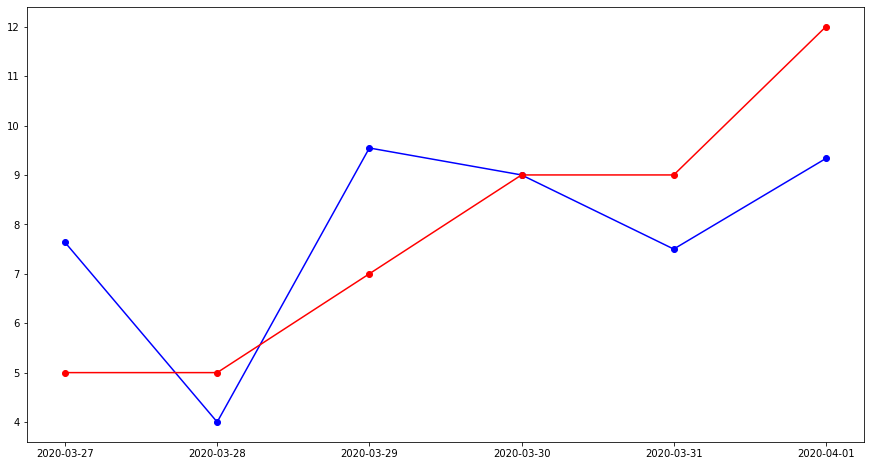

In [276]:
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime


results = test[['date', 'Region', 'predicted_nbr_in_3_days']]
results['date'] = [str(datetime.strptime(day, '%Y-%m-%d').date()+timedelta(days=3)) for day in results['date']]
results.columns = ['date', 'Region', 'predicted']

results = results.merge(data, on=['date', 'Region'], how='left')[['date', 'Region', 'predicted', 'iva']]

i = 2
print(regioner[i])

f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)
ax.plot(results[results['Region'] == regioner[i]]['date'], 
        results[results['Region'] == regioner[i]]['predicted'],
        '-ob'
       )
ax.plot(results[results['Region'] == regioner[i]]['date'],
        results[results['Region'] == regioner[i]]['iva'],
        '-or'
       )

plt.show()

